# Toy demo: what `correct_fermi_edge` does

This notebook creates a *very small* ARPES-like intensity map (energy × angle) and demonstrates the core idea of `BandMap.correct_fermi_edge()`:

- For each **angle**, estimate the **Fermi-edge position** (conceptually: fit a Fermi-Dirac edge).
- Fit the edge position vs angle with a **line** (offset + slope).
- Use that slope to **warp / resample** the 2D intensity map along the **energy axis** so the edge aligns across angles.

Plot labels are in English.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
rng = np.random.default_rng(0)

## 1) Build a tiny "ibw-like" dataset (energy × angle)

In an `.ibw`, `wData` is essentially a 2D array with shape:

- **rows** = energy index
- **cols** = angle index

Here we create:
- `ekin` (1D, eV)
- `angles` (1D, deg)
- `intensities` (2D, counts)

In [3]:
# Tiny axes
angles = np.array([-4.0, -2.0, 0.0, 2.0, 4.0])                 # deg (n_angle = 5)
ekin   = np.array([31.96, 32.00, 32.04, 32.08, 32.12, 32.16])  # eV  (n_energy = 6)

nE = ekin.size
nA = angles.size

# True (constructed) angle-dependent edge position: hnu - Phi(angle) = offset + slope*angle
offset_true = 32.012   # eV
slope_true  = 0.0008   # eV/deg  (non-zero on purpose)
hnuminPhi_true = offset_true + slope_true * angles  # shape (n_angle,)

# Simple Fermi-Dirac-like step for synthetic edges
kT = 0.004  # eV (~46 K)

def fermi_dirac(E, mu, kT):
    x = np.clip((E - mu) / kT, -200, 200)
    return 1.0 / (np.exp(x) + 1.0)

# Build synthetic intensities: background + weight * FD(E; mu=hnu-Phi(angle)) + noise
background = 50.0
weight     = 800.0

E  = ekin[:, None]               # (nE, 1)
mu = hnuminPhi_true[None, :]     # (1, nA)

intensities = background + weight * fermi_dirac(E, mu=mu, kT=kT)
intensities += rng.normal(scale=8.0, size=intensities.shape)

print("intensities shape:", intensities.shape)
print("angles shape:", angles.shape)
print("ekin shape:", ekin.shape)

intensities shape: (6, 5)
angles shape: (5,)
ekin shape: (6,)


## 2) Visualize the map (before correction)

Because we injected an angle-dependent shift of the Fermi edge, the edge is *tilted* across angles.

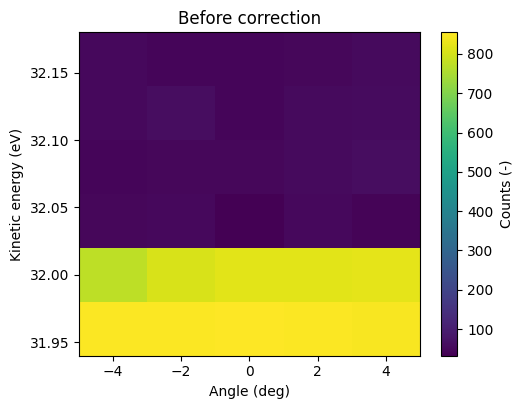

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 4.2))

mesh = ax.pcolormesh(angles, ekin, intensities, shading="auto", cmap="viridis")
ax.set_title("Before correction")
ax.set_xlabel("Angle (deg)")
ax.set_ylabel("Kinetic energy (eV)")
fig.colorbar(mesh, ax=ax, label="Counts (-)")
plt.show()

## 3) Estimate the Fermi-edge position for each angle

In `xarpes.BandMap.correct_fermi_edge()`, each angle column is fitted with a (resolution-broadened) Fermi-Dirac edge to estimate `hnu - Phi`.

To keep this toy notebook dependency-free, we use a simple estimator:

- For each angle column, find the energy where the intensity crosses **half-maximum**.

This gives an approximate edge position `nmps(angle)`.

In [11]:
def estimate_edge_halfmax(ekin_axis, counts_col):
    """Return the energy where counts crosses half-maximum (linear interpolation)."""
    c = counts_col
    cmin = np.nanmin(c)
    cmax = np.nanmax(c)
    half = 0.5 * (cmin + cmax)

    # We look for the first index where counts drops below half (edge-like step).
    # For real data you'd use a robust fit; this is only for demonstration.

    # the index where counts drops below half
    idx = np.where(c < half)[0]
    if len(idx) == 0:
        return np.nan

    i = idx[0]
    if i == 0:
        return ekin_axis[0]

    # interpolate between i-1 and i
    x0, x1 = ekin_axis[i - 1], ekin_axis[i]
    y0, y1 = c[i - 1], c[i]
    if y1 == y0:
        return x1
    return x0 + (half - y0) * (x1 - x0) / (y1 - y0)

nmps_est = np.array([estimate_edge_halfmax(ekin, intensities[:, j]) for j in range(nA)])

print("True edge positions  (hnu-Phi):", np.round(hnuminPhi_true, 6))
print("Estimated positions  (nmps_est):", np.round(nmps_est, 6))

True edge positions  (hnu-Phi): [32.0088 32.0104 32.012  32.0136 32.0152]
Estimated positions  (nmps_est): [32.017892 32.019018 32.019099 32.019238 32.019402]
